In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import os
import random
import seaborn as sns
from tqdm import tqdm
from tqdm import tnrange
from time import time

from sklearn.covariance import MinCovDet
from scipy.stats import chi2


from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, linear_model
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.preprocessing import minmax_scale, OneHotEncoder
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Input, Dense, Reshape, Concatenate, Flatten, Lambda, Reshape, Dropout
from keras.losses import MeanSquaredError as mse
from tensorflow.keras import backend as K
from keras.optimizers import Adam


In [2]:
DATASETS_PATH = "C:/Users/ernest.liu/Documents/git/Morphine-22-23/ML/Datasets/19-01-2023/"
os.chdir(DATASETS_PATH)
os.listdir()

['fall_simulation',
 'fall_simulation2',
 'fall_simulation3',
 'fall_simulation_2.csv',
 'fall_simulation_3.csv',
 'trial_data_1',
 'trial_data_2',
 'trial_data_3',
 'trial_data_4',
 'trial_data_4.csv',
 'trial_data_5',
 'trial_data_5.csv']

In [3]:
adl_files = [file_name for file_name in os.listdir() if ".csv" in file_name and "trial" in file_name]
fall_files = [file_name for file_name in os.listdir() if ".csv" in file_name and "fall" in file_name]

print(adl_files)
print(fall_files)

['trial_data_4.csv', 'trial_data_5.csv']
['fall_simulation_2.csv', 'fall_simulation_3.csv']


In [4]:
trial_data_4 = pd.read_csv(DATASETS_PATH+'trial_data_4.csv').iloc[:,1:]
trial_data_5 = pd.read_csv(DATASETS_PATH+'trial_data_5.csv').iloc[:,1:]

fall_simulation_2 = pd.read_csv(DATASETS_PATH+'fall_simulation_2.csv').iloc[:,1:]
fall_simulation_3 = pd.read_csv(DATASETS_PATH+'fall_simulation_3.csv').iloc[:,1:]

In [5]:
# Only take in accelerometer and gyroscope data
trial_data_4 = trial_data_4[['Ax','Ay','Az','gx','gy','gz']]
trial_data_5 = trial_data_5[['Ax','Ay','Az','gx','gy','gz']]

fall_simulation_2 = fall_simulation_2[['Ax','Ay','Az','gx','gy','gz']]
fall_simulation_3 = fall_simulation_3[['Ax','Ay','Az','gx','gy','gz']]

In [6]:
train_data = pd.concat([trial_data_4, trial_data_5]).reset_index(drop=True)
test_data = pd.concat([fall_simulation_2, fall_simulation_3]).reset_index(drop=True)

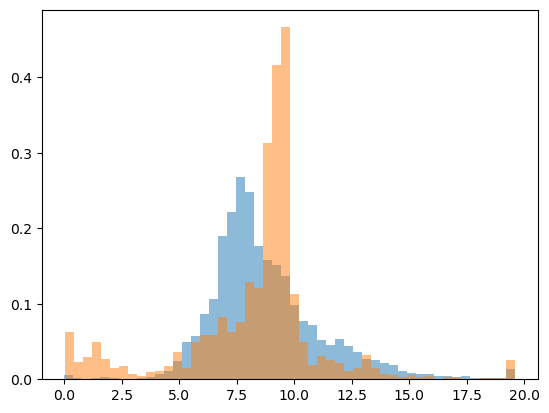

In [7]:
# EDA
plt.hist(np.abs(train_data.Ay), bins=50, alpha=0.5, density=True)
plt.hist(np.abs(test_data.Ay), bins=50, alpha=0.5, density=True)
plt.show()

In [8]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(train_data)

MinMaxScaler()

In [9]:
train_data_norm_presplit = scaler.transform(train_data)
test_data_norm = scaler.transform(test_data)

In [10]:
valid_ratio = 0.2
valid_indices = sorted(random.sample(list(range(train_data_norm_presplit.shape[0])), round(train_data_norm_presplit.shape[0] * valid_ratio)))

In [11]:
valid_data = train_data.iloc[valid_indices, :].reset_index(drop = True)
valid_data_norm = train_data_norm_presplit[valid_indices]
train_data_norm = np.delete(train_data_norm_presplit, valid_indices, axis = 0)

## Mahalanobis Distance Outlier Removal

In [ ]:
# Covariance matrix
# covariance = np.cov(train_data, rowvar=False)

start_time = time()
cov = MinCovDet().fit(train_data_norm)
end_time = time()
print(f"Time elapsed: {(end_time - start_time)/60} minutes")
covariance = cov.covariance_

covariance = np.cov(train_data_norm, rowvar=False)

# Covariance matrix power of -1
covariance_pm1 = np.linalg.matrix_power(covariance, -1)

# Center point
centerpoint = np.mean(train_data_norm, axis=0)

In [ ]:
# Distances between center point and 
distances = []
for i, val in enumerate(train_data_norm):
    p1 = val
    p2 = centerpoint
    distance = (p1-p2).T.dot(covariance_pm1).dot(p1-p2)
    distances.append(distance)
distances = np.array(distances)

# Cutoff (threshold) value from Chi-Sqaure Distribution for detecting outliers 
cutoff_threshold = 0.99
cutoff = chi2.ppf(cutoff_threshold, train_data_norm.shape[1])

# Index of outliers
outlierIndexes = np.where(distances > cutoff)

print('--- Index of Outliers ----')
print(outlierIndexes)
print(f"There are {len(outlierIndexes[0])} outliers identified")

print('--- Observations found as outlier -----')
print(train_data_norm[distances > cutoff, :])

train_data_norm = np.delete(train_data_norm, outlierIndexes, axis = 0)

## Building Model

In [ ]:
latent_space_dim = 2
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(latent_space_dim,), mean=0., stddev=1.) # stddev is set to 0.1 in this post: https://blog.keras.io/building-autoencoders-in-keras.html
    return_value = z_mean + K.exp(z_log_sigma) * epsilon
    #print(z_mean)
    
    return return_value

### Encoder

In [ ]:
inputs = Input((6,))
layer1 = Dense(6, activation = 'relu')(inputs)
layer2 = Dense(200, activation = 'relu')(layer1) # Changed from 3
layer3 = Dense(100, activation = 'relu')(layer2) # Changed from 3
layer4 = Dense(60, activation = 'relu')(layer3)
layer5 = Dense(30, activation = 'relu')(layer4)
z_mean = Dense(latent_space_dim)(layer5)
z_log_sigma = Dense(latent_space_dim)(layer5)
encoder = keras.Model(inputs, [z_mean, z_log_sigma], name="encoder")
encoder.summary()

### Sampler

In [ ]:
sampler_input1 = keras.Input(shape=(latent_space_dim,))
sampler_input2 = keras.Input(shape=(latent_space_dim,))
latent_sample = Lambda(sampling, output_shape = (latent_space_dim,))([sampler_input1, sampler_input2])
sampler = keras.Model([sampler_input1, sampler_input2], latent_sample)

### Decoder

In [ ]:
latent_inputs = keras.Input(shape=(latent_space_dim,))
layer6 = Dense(20, activation = 'relu')(latent_inputs)
layer7 = Dense(30, activation = 'relu')(layer6)
layer8 = Dense(50, activation = 'relu')(layer7)
layer9 = Dense(100, activation = 'relu')(layer8)
layer10 = Dense(200, activation = 'relu')(layer9)
decoder_outputs = Dense(6, activation = 'sigmoid')(layer10)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

## VAE

In [ ]:
class VAE(Model):
    def __init__(self, encoder, sampler, decoder, beta = 1, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.sampler = sampler
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_sigma = self.encoder(data)
            z_log_var = 2 * z_log_sigma
            z = self.sampler([z_mean, z_log_var])
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstruction))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    def test_step(self, data):
        if isinstance(data, tuple):
            #print(f"Ran. data: {data}")
            data = data[0]

        z_mean, z_log_sigma = self.encoder(data)
        z_log_var = 2 * z_log_sigma
        z = self.sampler([z_mean, z_log_var])
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstruction))
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss)
        total_loss = reconstruction_loss + self.beta * kl_loss
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    
    def call(self, data):
        z_mean, z_log_sigma = self.encoder(data)
        z_log_var = 2 * z_log_sigma
        z = self.sampler([z_mean, z_log_var])
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstruction))
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss)
        total_loss = reconstruction_loss + self.beta * kl_loss
        self.add_metric(kl_loss, name='kl_loss', aggregation='mean')
        self.add_metric(total_loss, name='total_loss', aggregation='mean')
        self.add_metric(reconstruction_loss, name='reconstruction_loss', aggregation='mean')
        return reconstruction
    

In [ ]:
vae = VAE(encoder, sampler, decoder, beta = 0.01)
vae.compile(optimizer = 'adam')

In [ ]:
callback = EarlyStopping(
    monitor="val_loss",
    patience=5
)

history = vae.fit(x = train_data_norm, y = train_data_norm, # Changed from train_data_norm 
                  epochs = 1000,
                  shuffle = True,
                  batch_size = 32,
                  workers = 8,
                  validation_data = (valid_data_norm, valid_data_norm), # Changed from valid_data_norm
                  callbacks = [callback])

In [ ]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

In [ ]:
train_predictions = vae.predict(train_data_norm)
test_predictions = vae.predict(test_data_norm)
valid_predictions = vae.predict(valid_data_norm)

In [ ]:
model_name = "vae_fixed_loss_beta_0_01"
#os.chdir("C:/Users/ernest.liu/Documents/git/Morphine-22-23/ML/Model/weights/")
#vae.save_weights(model_name)

In [ ]:
print(f"Training MAE: {np.sum(np.abs(train_data_norm - train_predictions))/(train_data_norm.shape[0] * train_data_norm.shape[1])}")
print(f"Testing MAE (Anomalous Data): {np.sum(np.abs(test_data_norm - test_predictions))/(test_data_norm.shape[0] * test_data_norm.shape[1])}")
print(f"Validation MAE (Normal Data): {np.sum(np.abs(valid_data_norm - valid_predictions))/(valid_data_norm.shape[0] * valid_data_norm.shape[1])}")

In [ ]:
train_mae = np.sum(np.abs(train_data_norm - train_predictions), axis = 1)
plt.hist(train_mae, bins = 20)
plt.title("Training Dataset")
plt.xlabel("Reconstruction Error (MAE)")
plt.ylabel("Count")
plt.show()

In [ ]:
valid_mae = np.sum(np.abs(valid_data_norm - valid_predictions), axis = 1)
plt.hist(valid_mae, bins = 20)
plt.title("Validation (Normal Samples) Dataset")
plt.xlabel("Reconstruction Error (MAE)")
plt.ylabel("Count")
plt.show()

In [ ]:
test_mae = np.sum(np.abs(test_data_norm - test_predictions), axis = 1)
plt.hist(test_mae, bins = 20)
plt.title("Testing (Anomalous) Dataset")
plt.xlabel("Reconstruction Error (MAE)")
plt.ylabel("Count")
plt.show()

In [ ]:
best_threshold = np.quantile(valid_mae, 0.9)

In [ ]:
best_threshold

In [ ]:
train_data["mae"] = np.sum(np.abs(scaler.transform(train_data) - vae.predict(scaler.transform(train_data))), axis = 1)
train_data["is_anomalous"] = train_data.mae > best_threshold

test_data["mae"] = test_mae
test_data["is_anomalous"] = test_mae > best_threshold

In [ ]:
test_data

In [ ]:
plt.scatter(test_data.index, test_data.mae, s = 0.2)
plt.axhline(y=best_threshold, color='r', linestyle='-')
plt.show()

In [ ]:
plt.scatter(train_data.index, train_data.mae, s = 0.2)
plt.axhline(y=best_threshold, color='r', linestyle='-')
plt.show()

In [ ]:
np.sum(test_data.is_anomalous)/test_data.shape[0]

In [ ]:
np.sum(train_data.is_anomalous)/train_data.shape[0]

## Loading Model

In [12]:
latent_space_dim = 2
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(latent_space_dim,), mean=0., stddev=1.) # stddev is set to 0.1 in this post: https://blog.keras.io/building-autoencoders-in-keras.html
    return_value = z_mean + K.exp(z_log_sigma) * epsilon
    #print(z_mean)
    
    return return_value

In [13]:
inputs = Input((6,))
layer1 = Dense(6, activation = 'relu')(inputs)
layer2 = Dense(200, activation = 'relu')(layer1) # Changed from 3
layer3 = Dense(100, activation = 'relu')(layer2) # Changed from 3
layer4 = Dense(60, activation = 'relu')(layer3)
layer5 = Dense(30, activation = 'relu')(layer4)
z_mean = Dense(latent_space_dim)(layer5)
z_log_sigma = Dense(latent_space_dim)(layer5)
encoder = keras.Model(inputs, [z_mean, z_log_sigma], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 6)            42          ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 200)          1400        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 100)          20100       ['dense_1[0][0]']                
                                                                                            

In [14]:
sampler_input1 = keras.Input(shape=(latent_space_dim,))
sampler_input2 = keras.Input(shape=(latent_space_dim,))
latent_sample = Lambda(sampling, output_shape = (latent_space_dim,))([sampler_input1, sampler_input2])
sampler = keras.Model([sampler_input1, sampler_input2], latent_sample)

In [15]:
latent_inputs = keras.Input(shape=(latent_space_dim,))
layer6 = Dense(20, activation = 'relu')(latent_inputs)
layer7 = Dense(30, activation = 'relu')(layer6)
layer8 = Dense(50, activation = 'relu')(layer7)
layer9 = Dense(100, activation = 'relu')(layer8)
layer10 = Dense(200, activation = 'relu')(layer9)
decoder_outputs = Dense(6, activation = 'sigmoid')(layer10)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_7 (Dense)             (None, 20)                60        
                                                                 
 dense_8 (Dense)             (None, 30)                630       
                                                                 
 dense_9 (Dense)             (None, 50)                1550      
                                                                 
 dense_10 (Dense)            (None, 100)               5100      
                                                                 
 dense_11 (Dense)            (None, 200)               20200     
                                                                 
 dense_12 (Dense)            (None, 6)                 1206

In [16]:
class VAE(Model):
    def __init__(self, encoder, sampler, decoder, beta = 1, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.sampler = sampler
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_sigma = self.encoder(data)
            z_log_var = 2 * z_log_sigma
            z = self.sampler([z_mean, z_log_var])
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstruction))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    def test_step(self, data):
        if isinstance(data, tuple):
            #print(f"Ran. data: {data}")
            data = data[0]

        z_mean, z_log_sigma = self.encoder(data)
        z_log_var = 2 * z_log_sigma
        z = self.sampler([z_mean, z_log_var])
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstruction))
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss)
        total_loss = reconstruction_loss + self.beta * kl_loss
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    
    def call(self, data):
        z_mean, z_log_sigma = self.encoder(data)
        z_log_var = 2 * z_log_sigma
        z = self.sampler([z_mean, z_log_var])
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstruction))
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss)
        total_loss = reconstruction_loss + self.beta * kl_loss
        self.add_metric(kl_loss, name='kl_loss', aggregation='mean')
        self.add_metric(total_loss, name='total_loss', aggregation='mean')
        self.add_metric(reconstruction_loss, name='reconstruction_loss', aggregation='mean')
        return reconstruction
    

In [17]:
vae = VAE(encoder, sampler, decoder, beta = 0.01)
vae.compile(optimizer = 'adam')

In [18]:
os.chdir("C:/Users/ernest.liu/Documents/git/Morphine-22-23/ML/Model/weights/")
model_name = "vae_fixed_loss_beta_0_01"
vae.load_weights(model_name)